# Illustrate cancer growth model and filters

In [45]:
import os
import string

import chi
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, lognorm, gaussian_kde
import seaborn as sns
sns.set_theme()

from exponential_growth_model import ExponentialGrowthModel

The data-generating model is a hierarchical exponential growth model governed
by

$$
    p(y, \psi | \theta , t) = p(y | \psi , t)\, p(\psi | \theta),
$$

where $\psi = (y_0, \lambda, \sigma)$ and
$\theta = (\mu_{y_0}, \mu_{\lambda}, \sigma_{y_0}, \sigma_{\lambda}, \theta_{\sigma})$.
The measurements of individuals are governed by a distribution defined by the
mechanistic model-error model pair

$$
    p(y | \psi , t) = \mathcal{N}(y | y_0\mathrm{e}^{\lambda t}, \sigma ^2),
$$

and the inter-individual variability is governed by the population model

$$
    p(\psi | \theta) =
        \mathcal{N}(y_0 | \mu_{y_0}, \sigma ^2_{y_0})\,
        \mathcal{N}(\lambda | \mu_{\lambda}, \sigma ^2_{\lambda})\,
        \delta (\sigma - \theta_{\sigma}).
$$

## Define model

In [5]:
# Define model
mechanistic_model = ExponentialGrowthModel()
population_model = chi.GaussianModel(
    n_dim=2, dim_names=['Initial count', 'Growth rate'],
    centered=True)

# Define parameters
true_parameters = [
    10,    # Mean initial condition
    2,     # Mean exponential growth
    1,     # Std. initial condition
    0.5]   # Std. exponential growth

## Visualise model

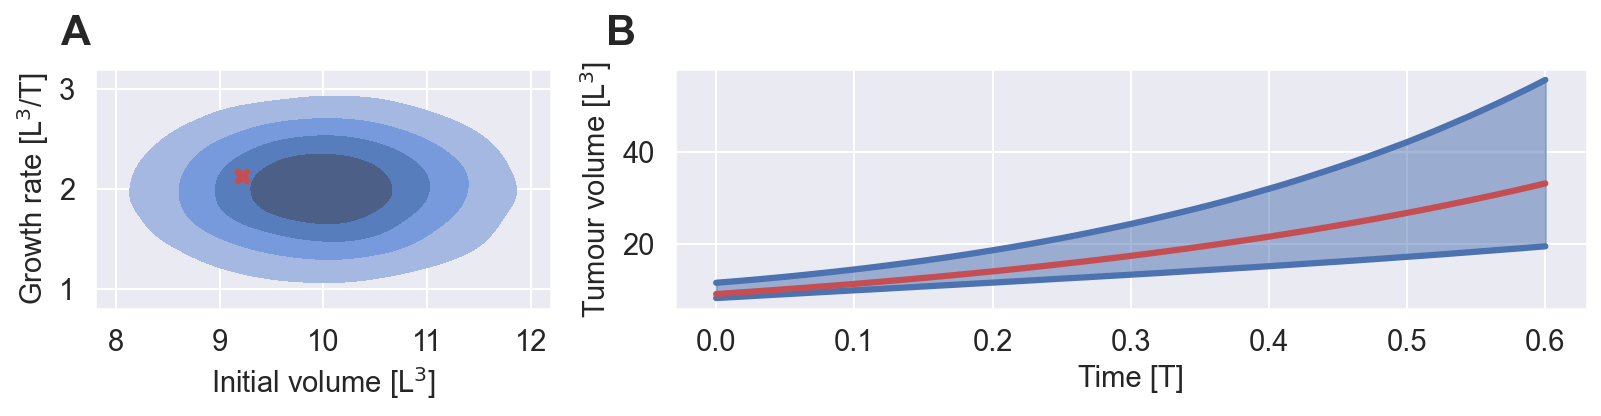

In [35]:
# Create layout
fontsize = 14
my_dpi = 192
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150,
    gridspec_kw={'width_ratios': [1, 2]})

# Label subplot groups
axes[0].text(
    -0.075, 1.1, string.ascii_uppercase[0], transform=axes[0].transAxes,
    size=20, weight='bold')
axes[1].text(
    -0.075, 1.1, string.ascii_uppercase[1], transform=axes[1].transAxes,
    size=20, weight='bold')

# Plot data-generating distribution as reference to parameter space
seed = 10
n_samples = 50000
samples = population_model.sample(true_parameters, n_samples, seed)
sns.kdeplot(
    x=samples[:, 0], y=samples[:, 1], fill=True, bw_adjust=1.5,
    levels=[0.2, 0.4, 0.6, 0.8, 1], ax=axes[0])

# Plot data-generating distribution as reference to measurement space
n_steps = 100
times = np.linspace(0, 0.6, num=n_steps)
volumes = np.empty(shape=(n_samples, n_steps))
for ids, s in enumerate(samples):
    volumes[ids] = mechanistic_model.simulate(s, times)
fifth_percentile = np.quantile(volumes, q=0.05, axis=0)
ninetyfifth_percentile = np.quantile(volumes, q=0.95, axis=0)
axes[1].plot(
    times, fifth_percentile, color=sns.color_palette()[0], linewidth=3)
axes[1].plot(
    times, ninetyfifth_percentile, color=sns.color_palette()[0], linewidth=3)
axes[1].fill_between(
    times, fifth_percentile, ninetyfifth_percentile,
    color=sns.color_palette()[0], alpha=0.5)

# Plot individual
_id = 1
axes[0].scatter(
    samples[_id, 0], samples[_id, 1], color=sns.color_palette()[3], marker='x',
    linewidth=3)
axes[1].plot(times, volumes[_id], color=sns.color_palette()[3], linewidth=3)

# Legend, ranges axes labels
axes[1].set_xlabel('Time [T]', fontsize=fontsize)
axes[1].set_ylabel(r'Tumour volume [L$^3$]', fontsize=fontsize)
axes[0].tick_params(labelsize=fontsize)
axes[0].set_xlim([7.8, 12.2])
axes[0].set_ylim([0.8, 3.2])
axes[0].set_xlabel(r'Initial volume [L$^3$]', fontsize=fontsize)
axes[0].set_ylabel(r'Growth rate [L$^3$/T]', fontsize=fontsize)
axes[1].tick_params(labelsize=fontsize)

# Export figure
directory = os.getcwd()
plt.savefig(
    directory + '/0_nlme_model_example.tif',
    bbox_inches='tight')
plt.savefig(
    directory + '/0_nlme_model_example.pdf',
    bbox_inches='tight')

plt.tight_layout()

## Visualise filters

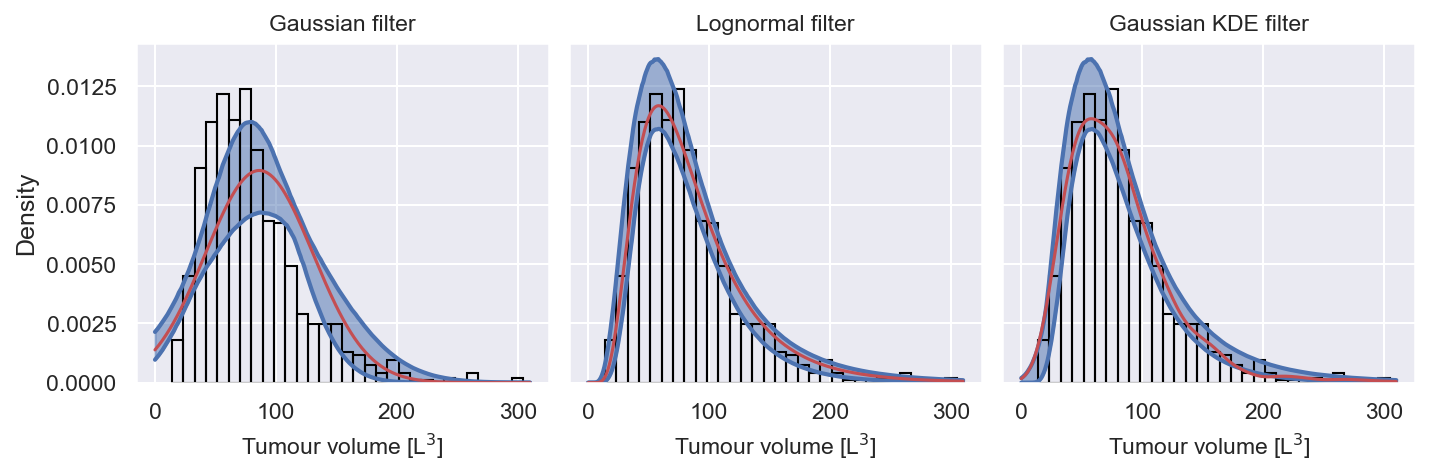

In [61]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 3, wspace=0.05, hspace=0.05)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0, 0]))
axes.append(plt.Subplot(fig, outer[0, 1]))
axes.append(plt.Subplot(fig, outer[0, 2]))

# Share axes
for idx in range(2):
    axes[idx].sharey(axes[idx+1])

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot filter approximations
n_steps = 300
volume_range = np.linspace(0, 310, n_steps)
seed = 2
n_samples = 100 * 1000
samples = population_model.sample(true_parameters, n_samples, seed)
volumes = np.empty(shape=(n_samples))
for ids, s in enumerate(samples):
    volumes[ids] = mechanistic_model.simulate(s, [1])[0]
volumes = volumes.reshape(100, 1000)

# Plot Gaussian filter
densities = np.empty(shape=(1000, n_steps))
means = np.mean(volumes, axis=0)
stds = np.std(volumes, ddof=1, axis=0)
for idm, m in enumerate(means):
    densities[idm] = norm.pdf(volume_range, loc=m, scale=stds[idm])
fifth_percentile = np.quantile(densities, q=0.05, axis=0)
ninetyfifth_percentile = np.quantile(densities, q=0.95, axis=0)
axes[0].plot(
    volume_range, fifth_percentile, color=sns.color_palette()[0], linewidth=2)
axes[0].plot(
    volume_range, ninetyfifth_percentile, color=sns.color_palette()[0], linewidth=2)
axes[0].fill_between(
    volume_range, fifth_percentile, ninetyfifth_percentile,
    color=sns.color_palette()[0], alpha=0.5)
axes[0].plot(volume_range, densities[0], color=sns.color_palette()[3])

# Plot lognormal filter
densities = np.empty(shape=(1000, n_steps))
means = np.mean(np.log(volumes), axis=0)
stds = np.std(np.log(volumes), ddof=1, axis=0)
for idm, m in enumerate(means):
    densities[idm] = lognorm.pdf(volume_range, scale=np.exp(m), s=stds[idm])
fifth_percentile = np.quantile(densities, q=0.05, axis=0)
ninetyfifth_percentile = np.quantile(densities, q=0.95, axis=0)
axes[1].plot(
    volume_range, fifth_percentile, color=sns.color_palette()[0], linewidth=2)
axes[1].plot(
    volume_range, ninetyfifth_percentile, color=sns.color_palette()[0], linewidth=2)
axes[1].fill_between(
    volume_range, fifth_percentile, ninetyfifth_percentile,
    color=sns.color_palette()[0], alpha=0.5)
axes[1].plot(volume_range, densities[0], color=sns.color_palette()[3])

# Plot Gaussian KDE filter
densities = np.empty(shape=(1000, n_steps))
for idv, v in enumerate(volumes):
    densities[idv] = gaussian_kde(v)(volume_range)
fifth_percentile = np.quantile(densities, q=0.05, axis=0)
ninetyfifth_percentile = np.quantile(densities, q=0.95, axis=0)
axes[2].plot(
    volume_range, fifth_percentile, color=sns.color_palette()[0], linewidth=2)
axes[2].plot(
    volume_range, ninetyfifth_percentile, color=sns.color_palette()[0], linewidth=2)
axes[2].fill_between(
    volume_range, fifth_percentile, ninetyfifth_percentile,
    color=sns.color_palette()[0], alpha=0.5)
axes[2].plot(volume_range, densities[0], color=sns.color_palette()[3])

# Plot data-generating distribution
seed = 10
n_samples = 1000
samples = population_model.sample(true_parameters, n_samples, seed)
volumes = np.empty(shape=(n_samples))
for ids, s in enumerate(samples):
    volumes[ids] = mechanistic_model.simulate(s, [1])[0]
for ax in axes:
    sns.histplot(volumes, ax=ax, stat='density', fill=False, color='black', linewidth=1)
    #sns.kdeplot(volumes, fill=False, bw_adjust=1.5, ax=ax, color='black')

# Add labels
for ax in axes[1:]:
    ax.set_yticklabels([])
    ax.set_ylabel('')

titles = ['Gaussian filter', 'Lognormal filter', 'Gaussian KDE filter']
for ida, ax in enumerate(axes):
    ax.set_title(titles[ida], fontsize=fontsize)
    ax.set_xlabel('Tumour volume [L$^3$]', fontsize=fontsize)

# Export figure
directory = os.getcwd()
plt.savefig(
    directory + '/00_filter_example.tif',
    bbox_inches='tight')
plt.savefig(
    directory + '/00_filter_example.pdf',
    bbox_inches='tight')

plt.show()